## GPU Setup

In [1]:
# Check
from subprocess import getoutput
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader
print("\n")

# Setup
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
%pip install gputil
%pip install psutil
%pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

# Print Details
!nvidia-smi

GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

NVIDIA GeForce RTX 3060 Ti, 8192 MiB, 7441 MiB


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Wed May 18 01:59:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.68.02    Driver Version: 510.68.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|======

## Install Deps, Load Libraries 



In [2]:
# Dependencies
!git clone https://github.com/openai/CLIP
!git clone https://github.com/CompVis/taming-transformers
%pip install ftfy regex tqdm omegaconf pytorch-lightning
%pip install kornia
%pip install einops
%pip install transformers

fatal: destination path 'CLIP' already exists and is not an empty directory.
fatal: destination path 'taming-transformers' already exists and is not an empty directory.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [32]:
# Load Libraries and Variables
import argparse
import math
from pathlib import Path
import sys

sys.path.append('./taming-transformers')

from IPython import display
from omegaconf import OmegaConf
from PIL import Image
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
import numpy as np
import os.path
from os import path
from urllib.request import Request, urlopen
 
from CLIP import clip
import kornia
import kornia.augmentation as K
from torch.utils.checkpoint import checkpoint

from matplotlib import pyplot as plt
from fastprogress.fastprogress import master_bar, progress_bar
import random
import gc

import re
from datetime import datetime

from base64 import b64encode

import warnings

warnings.filterwarnings('ignore')
torch.set_printoptions( sci_mode=False )

def noise_gen(shape, octaves=5):
    n, c, h, w = shape
    noise = torch.zeros([n, c, 1, 1])
    max_octaves = min(octaves, math.log(h)/math.log(2), math.log(w)/math.log(2))
    for i in reversed(range(max_octaves)):
        h_cur, w_cur = h // 2**i, w // 2**i
        noise = F.interpolate(noise, (h_cur, w_cur), mode='bicubic', align_corners=False)
        noise += torch.randn([n, c, h_cur, w_cur]) / 5
    return noise


def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))


def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()


def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]


def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.view([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)
    

# def replace_grad(fake, real):
#     return fake.detach() - real.detach() + real


class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)


class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)

    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None

replace_grad = ReplaceGrad.apply

clamp_with_grad = ClampWithGrad.apply
# clamp_with_grad = torch.clamp

def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)


class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))

    def forward(self, input):
        
        input_normed = F.normalize(input.unsqueeze(1), dim=2)#(input / input.norm(dim=-1, keepdim=True)).unsqueeze(1)# 
        embed_normed = F.normalize((self.embed).unsqueeze(0), dim=2)#(self.embed / self.embed.norm(dim=-1, keepdim=True)).unsqueeze(0)#

        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()


def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])

def one_sided_clip_loss(input, target, labels=None, logit_scale=100):
    input_normed = F.normalize(input, dim=-1)
    target_normed = F.normalize(target, dim=-1)
    logits = input_normed @ target_normed.T * logit_scale
    if labels is None:
        labels = torch.arange(len(input), device=logits.device)
    return F.cross_entropy(logits, labels)

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

    def set_cut_pow(self, cut_pow):
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        cutouts_full = []
        
        min_size_width = min(sideX, sideY)
        lower_bound = float(self.cut_size/min_size_width)
        
        for ii in range(self.cutn):
            size = int(min_size_width*torch.zeros(1,).normal_(mean=.8, std=.3).clip(lower_bound, 1.)) # replace .5 with a result for 224 the default large size is .95
          
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))

        cutouts = torch.cat(cutouts, dim=0)

        return clamp_with_grad(cutouts, 0, 1)


def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model

def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

class GaussianBlur2d(nn.Module):
    def __init__(self, sigma, window=0, mode='reflect', value=0):
        super().__init__()
        self.mode = mode
        self.value = value
        if not window:
            window = max(math.ceil((sigma * 6 + 1) / 2) * 2 - 1, 3)
        if sigma:
            kernel = torch.exp(-(torch.arange(window) - window // 2)**2 / 2 / sigma**2)
            kernel /= kernel.sum()
        else:
            kernel = torch.ones([1])
        self.register_buffer('kernel', kernel)

    def forward(self, input):
        n, c, h, w = input.shape
        input = input.view([n * c, 1, h, w])
        start_pad = (self.kernel.shape[0] - 1) // 2
        end_pad = self.kernel.shape[0] // 2
        input = F.pad(input, (start_pad, end_pad, start_pad, end_pad), self.mode, self.value)
        input = F.conv2d(input, self.kernel[None, None, None, :])
        input = F.conv2d(input, self.kernel[None, None, :, None])
        return input.view([n, c, h, w])

class EMATensor(nn.Module):
    """implmeneted by Katherine Crowson"""
    def __init__(self, tensor, decay):
        super().__init__()
        self.tensor = nn.Parameter(tensor)
        self.register_buffer('biased', torch.zeros_like(tensor))
        self.register_buffer('average', torch.zeros_like(tensor))
        self.decay = decay
        self.register_buffer('accum', torch.tensor(1.))
        self.update()
    
    @torch.no_grad()
    def update(self):
        if not self.training:
            raise RuntimeError('update() should only be called during training')

        self.accum *= self.decay
        self.biased.mul_(self.decay)
        self.biased.add_((1 - self.decay) * self.tensor)
        self.average.copy_(self.biased)
        self.average.div_(1 - self.accum)

    def forward(self):
        if self.training:
            return self.tensor
        return self.average
  
import io
import base64
def image_to_data_url(img, ext):  
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format=ext)
    img_byte_arr = img_byte_arr.getvalue()
    # ext = filename.split('.')[-1]
    prefix = f'data:image/{ext};base64,'
    return prefix + base64.b64encode(img_byte_arr).decode('utf-8')
 

def update_random( seed, purpose ):
  if seed == -1:
    seed = random.seed()
    seed = random.randrange(1,99999)
    
  print( f'Using seed {seed} for {purpose}')
  random.seed(seed)
  torch.manual_seed(seed)
  np.random.seed(seed)

  return seed

def lerp(a,b,alpha):
    return (b-a)*alpha + a
    
def clear_memory():
  gc.collect()
  torch.cuda.empty_cache()

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## MakeCuts Class with Debug Functionality

In [19]:
#@title MakeCuts class with debug functionality
cut_sizes_should_use_large_dimension = False #@param {type:'boolean'}
cut_size_mode = "trunc_norm" #@param [ "normal", "trunc_norm", "cut_pow", "cut_map"]
cut_oversample = 0#@param {type:"slider", min:0, max:1, step:0.01}
std_factor = 1.5#@param {type:'number'}
cut_map_weight = 0.66#@param {type:'number'}
cut_map_size_weights = [0.6, 0.4, 0.2, 0.12] #@param
#@markdown ----

class MakeCutouts3(nn.Module):
    def __init__(self, min_cut, cutn, oversample=0., std_factor=1.5, cut_pow=1.):
        super().__init__()
        self.cutn = cutn
        
        self.oversample = oversample
        self.min_cut = torch.tensor([min_cut])
        self.std_factor = std_factor

        self.cut_pow = cut_pow
        self.cut_map_weight = cut_map_weight
        
    def simulate(self,input,runs=100):

        history = []
        for _ in range(runs):
            sizes, offsets, extents, weights = self.pick_cuts(input)
            history.append(sizes.squeeze())
        history = torch.cat( history, dim=0 )

        heat = torch.zeros(1,*input.shape[2:4])
        weights = weights / weights.sum()
        offsets = offsets.clamp_min(0)
        for i in range(self.cutn):
          heat[...,offsets[i,0]:extents[i,0],offsets[i,1]:extents[i,1]] += 1 / self.cutn

        heat = np.pi * 1.6 - heat * ( 1.3 * np.pi )
        heat = kornia.color.hsv_to_rgb( torch.stack( (heat, torch.ones_like(heat), torch.ones_like(heat)*1), dim=1))

        return history, heat

    def pick_sizes(self,dims,cutn,mode,allow_lb=False):

        if cut_sizes_should_use_large_dimension:
            max_size = dims.max().unsqueeze(0)
            min_size = torch.min( dims.min(), self.min_cut).unsqueeze(0)

            rand_size_mean = ( dims.prod() * self.min_cut ) ** ( 1/3. )
            rand_size_std = min( rand_size_mean - min_size, max_size - rand_size_mean ) * self.std_factor
        else:
            max_size = torch.max( dims.min(), self.min_cut )[None]
            min_size = torch.min( dims.min(), self.min_cut )[None]

            rand_size_mean = ( min_size * max_size ) ** (1/2.) 
            rand_size_std = min( abs(rand_size_mean - min_size), abs(max_size - rand_size_mean) ) * self.std_factor

        # use normal distribution... 
        if mode == 'normal':
            sizes = torch.FloatTensor(cutn,1).normal_( rand_size_mean.squeeze(), rand_size_std.squeeze() )
            sizes = sizes.clip( min_size, max_size ).int()

        # truncated normal distribution
        elif mode == 'trunc_norm':
            sizes = torch.nn.init.trunc_normal_(torch.FloatTensor(cutn,1), mean=rand_size_mean, std=rand_size_std, a=min_size, b=max_size ).int()

        # use cut pow...
        elif mode == 'cut_pow':
            sizes = torch.lerp( min_size.float(), max_size.float(), torch.rand(cutn,1) ** self.cut_pow ).int()
        
        elif mode == 'cut_map':
            
            sizemap = torch.tensor( [min_size, max_size, dims.max(), dims.prod() ** 0.5 ]).int()
            sizemap = sizemap.sort().values
            sizes = torch.tensor( list( torch.utils.data.WeightedRandomSampler( 
                cut_map_size_weights, cutn, replacement=True) ))
            sizes = sizemap[sizes[:,None]]
        
        return sizes

    def pick_cuts(self,input):
        dims = torch.tensor(input.shape[2:4]).unsqueeze(0)
        hdims = (dims/2).int()

        num_cut_maps = int( self.cutn * self.cut_map_weight )
        num_cuts = self.cutn - num_cut_maps

        sizes = []

        if num_cuts > 0:
            sizes.append(self.pick_sizes( dims, num_cuts, cut_size_mode, cut_sizes_should_use_large_dimension ))
        if num_cut_maps > 0:
            sizes.append(self.pick_sizes( dims, num_cut_maps, 'cut_map' ))
        
        sizes = torch.cat( sizes )
        hsizes = (sizes/2).int()

        over = ( sizes * self.oversample )

        center = torch.lerp( ( hsizes - over ).float(), ( dims - 1 - ( hsizes - over ) ).float(), torch.rand(self.cutn,2) ).int()
        center = torch.where( hsizes > ( dims - 1 - hsizes ), hdims,  # center image in cut if bigger than image
                     center.clip(hsizes, dims - 1 - hsizes))          # or clamp cut box to be within bounds

        offsets = ( center - hsizes )
        extents = ( offsets + sizes )
        
        # calculate cut area relative to whole
        weights = ( extents - offsets ).clamp_max(dims).prod(dim=1)

        return sizes, offsets, extents, weights.to(device)

    def make_cuts(self,input,cut_size,offsets,extents):

        # pad image to be square        
        dims = torch.tensor(input.shape[2:4])
        padding = ((dims.max() - dims )/2).int()

        mean = input.view(3,-1).mean(dim=1)

        fill = TF.pad( torch.zeros_like(input), ( padding[1], padding[0], padding[1], padding[0] ), padding_mode='constant', fill=1)
        fill = fill * mean.view(1,3,1,1)

        input = TF.pad( input, ( padding[1], padding[0], padding[1], padding[0] ), padding_mode='constant')

        offsets += padding
        extents += padding

        fill_rand_mul = torch.FloatTensor(self.cutn).uniform_(0,2.0)

        cutouts = []
        for i in range( self.cutn ):
            cutout = input[...,offsets[i,0]:extents[i,0],offsets[i,1]:extents[i,1]] \
                + fill[...,offsets[i,0]:extents[i,0],offsets[i,1]:extents[i,1]] * fill_rand_mul[i]
            cutout = resample(cutout, (cut_size, cut_size))
            cutouts.append(cutout)
 
        cutouts = torch.cat(cutouts, dim=0)
        return cutouts

    def forward(self,input):
        sizes, offsets, extents, weights = self.pick_cuts(input)        
        cutouts = self.make_cuts(input,self.min_cut,offsets,extents)
        
        return cutouts, weights

def show_images(images, width=20, height=5, columns = 5):
    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width,height))
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

should_test = False #@param {type:'boolean'}
show_histogram = False #@param {type:'boolean'}
show_cuts = False #@param {type:'boolean'}

if should_test:
    a = torch.rand( 1,3,496, 994 )
    #a = TF.to_tensor(Image.open('test.png')).unsqueeze(0)

    mk = MakeCutouts3( 224, 64, oversample=cut_oversample, std_factor =std_factor )

    seed = random.randrange(1,99999) 
    torch.random.manual_seed( seed )
    print('seed:', seed)

    if show_histogram:
        sizes,heat = mk.simulate(a)

        n,bins,patches = plt.hist(sizes,16,density=False, alpha=0.75)
        plt.xlabel('Cut Sizes',size=16)
        plt.ylabel('Counts',size=16)
        plt.title('Cut_Pow Method',size=18)
        plt.show()

        display.display(TF.to_pil_image(heat[0].cpu()))

    if show_cuts:
        cuts, weights = mk(a)

        images = [ TF.to_pil_image(c[0].cpu()) for c in cuts[:64].split(1)]
        show_images(images, columns=5)
        
          #display.display(TF.to_pil_image(c[0].cpu()))


## Loss Module Definitions

In [20]:
#@title Loss Module Definitions
from typing import cast, Dict, Optional
from kornia.augmentation import IntensityAugmentationBase2D

class FixPadding(nn.Module):
    
    def __init__(self, module=None, threshold=1e-12, noise_frac=0.00 ):
        super().__init__()

        self.threshold = threshold
        self.noise_frac = noise_frac

        self.module = module

    def forward(self,input):

        dims = input.shape

        if self.module is not None:
            input = self.module(input + self.threshold)

        light = input.new_empty(dims[0],1,1,1).uniform_(0.,2.)

        mixed = input.view(*dims[:2],-1).sum(dim=1,keepdim=True)

        black = mixed < self.threshold
        black = black.view(-1,1,*dims[2:4]).type(torch.float)
        black = kornia.filters.box_blur( black, (5,5) ).clip(0,0.1)/0.1

        mean = input.view(*dims[:2],-1).sum(dim=2) / mixed.count_nonzero(dim=2)
        mean = ( mean[:,:,None,None] * light ).clip(0,1)

        fill = mean.expand(*dims)
        if 0 < self.noise_frac:
            rng = torch.get_rng_state()
            fill = fill + torch.randn_like(mean) * self.noise_frac
            torch.set_rng_state(rng)
        
        if self.module is not None:
            input = input - self.threshold

        return torch.lerp(input,fill,black)


class MyRandomNoise(IntensityAugmentationBase2D):
    def __init__(
        self,
        frac: float = 0.1,
        return_transform: bool = False,
        same_on_batch: bool = False,
        p: float = 0.5,
    ) -> None:
        super().__init__(p=p, same_on_batch=same_on_batch, p_batch=1.0)
        self.frac = frac

    def __repr__(self) -> str:
        return self.__class__.__name__ + f"({super().__repr__()})"

    def generate_parameters(self, shape: torch.Size) -> Dict[str, torch.Tensor]:
        noise = torch.FloatTensor(1).uniform_(0,self.frac)
        
        # generate pixel data without throwing off determinism of augs
        rng = torch.get_rng_state()
        noise = noise * torch.randn(shape)
        torch.set_rng_state(rng)

        return dict(noise=noise)

    def apply_transform(
        self, input: torch.Tensor, params: Dict[str, torch.Tensor], transform: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        return input + params['noise'].to(input.device)


class MultiClipLoss(nn.Module):
    perceptors = {}

    def __init__(self, clip_models, normalize_prompt_weights, cutn, cut_weight_pow=0.5, clip_weight=1.):
        super().__init__()

        self.normalize_prompt_weights = normalize_prompt_weights

        # Load Clip
        for cm in { cm['model'] for cm in clip_models }:
            p = clip.load(cm, jit=False)[0].eval().requires_grad_(False).to(device)
            self.perceptors[cm] = { 'clip':p, 'res': int(p.visual.input_resolution) }

        self.perceptor_work = clip_models
        for pw in self.perceptor_work:
            p = self.perceptors[ pw['model']]
            pw['embeds'] = self.get_prompt_embeds( p['clip'], pw['prompt'] )
            pw['res'] = p['res']
    
        self.perceptor_work.sort(key=lambda e: e['res'], reverse=True)
        
        # Make Cutouts
        for p in self.perceptors:
            print( p )

        self.cut_sizes = list( { p['res'] for p in self.perceptors.values() } )
        self.cut_sizes.sort( reverse=True )
        
        self.cutter = MakeCutouts3(self.cut_sizes[-1], cutn, oversample=0.5, std_factor=1)
        self.cut_weight_pow = cut_weight_pow

        # Prep Augments
        self.noise_fac = 0.1
        self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])    
            
        self.noise_aug = MyRandomNoise(frac=self.noise_fac,p=1.)

        self.augs = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            K.RandomSharpness(0.3,p=0.1),
            FixPadding( nn.Sequential(
                K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='zeros'), # padding_mode=2
                K.RandomPerspective(0.2,p=0.4, ),
            )),
            K.ColorJitter(hue=0.01, saturation=0.01, p=0.7),
            K.RandomGrayscale(p=0.15), 
            self.noise_aug,
        )

        self.clip_weight = clip_weight
        

    def get_prompt_embeds( self, perceptor, text_prompt ):
    
            texts = [phrase.strip() for phrase in text_prompt.split("|")]
            if text_prompt == ['']:
                texts = []

            prompts_weight_sum = 0
            parsed_prompts = []
            for prompt in texts:
                txt, weight, stop = parse_prompt(prompt)
                parsed_prompts.append( [txt,weight,stop] )
                prompts_weight_sum += max( weight, 0 )

            prompt_embeds = []
            for prompt in parsed_prompts:
                txt, weight, stop = prompt
                clip_token = clip.tokenize(txt).to(device)

                if self.normalize_prompt_weights and 0 < prompts_weight_sum:
                    weight /= prompts_weight_sum

                embed = perceptor.encode_text(clip_token).float()
                embed_normed = F.normalize(embed.unsqueeze(0), dim=2)
                prompt_embeds.append({'embed_normed':embed_normed,'weight':torch.as_tensor(weight, device=device),'stop':torch.as_tensor(stop, device=device)})
        
            return prompt_embeds

    def make_cuts(self,img,currentres,offsets,extents,i):  
           
        cuts = self.cutter.make_cuts(img,currentres,offsets,extents)
        cuts = clamp_with_grad(cuts,0,1)
        cuts = self.augs( cuts )
        cuts = self.normalize(cuts)
        
        return cuts

    def forward( self, i, img ):
        
        sizes, offsets, extents, weights = self.cutter.pick_cuts(img)

        weights = weights[:,None] ** self.cut_weight_pow
        weights_sum = weights.sum()
        
        loss = []
        
        cuts = None
        currentres = 0
        
        rng = torch.get_rng_state()

        for pw in self.perceptor_work:
            if currentres != pw['res']:
                currentres = pw['res']

                torch.set_rng_state(rng) 
                cuts = self.make_cuts( img, currentres, offsets, extents, i )

            p = self.perceptors[pw['model']]
            iii = p['clip'].encode_image(cuts).float()
            input_normed = F.normalize(iii.unsqueeze(1), dim=2)
            for prompt in pw['embeds']:
                dists = input_normed.sub(prompt['embed_normed']).norm(dim=2).div(2).arcsin().pow(2).mul(2)
                dists = dists * prompt['weight'].sign()

                dists = replace_grad(dists, torch.maximum(dists, prompt['stop']))

###############################################################################                
                
                #l = dists.mean()
                l = ( dists * weights ).sum() / weights_sum
                
###############################################################################    
                
                loss.append(l * prompt['weight'].abs() * pw['weight'])

        return loss

class MSEDecayLoss(nn.Module):
    def __init__(self, init_weight, mse_decay_rate, mse_epoches, mse_quantize ):
        super().__init__()
      
        self.init_weight = init_weight
        self.has_init_image = False
        self.mse_decay = init_weight / mse_epoches if init_weight else 0 
        self.mse_decay_rate = mse_decay_rate
        self.mse_weight = init_weight
        self.mse_epoches = mse_epoches
        self.mse_quantize = mse_quantize

    @torch.no_grad()
    def set_target( self, z_tensor, model ):
        z_tensor = z_tensor.detach().clone()
        if self.mse_quantize:
            z_tensor = vector_quantize(z_tensor.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)#z.average
        self.z_orig = z_tensor
          
    def forward( self, i, z ):
        if self.is_active(i):
            return F.mse_loss(z, self.z_orig) * self.mse_weight / 2
        return 0
        
    def is_active(self, i):
        if not self.init_weight:
          return False
        if i <= self.mse_decay_rate and not self.has_init_image:
          return False
        return True

    @torch.no_grad()
    def step( self, i ):

        if i % self.mse_decay_rate == 0 and i != 0 and i < self.mse_decay_rate * self.mse_epoches:
            
            if self.mse_weight - self.mse_decay > 0 and self.mse_weight - self.mse_decay >= self.mse_decay:
              self.mse_weight -= self.mse_decay
            else:
              self.mse_weight = 0
            print(f"updated mse weight: {self.mse_weight}")

            return True

        return False
  
class TVLoss(nn.Module):
    def forward(self, input):
        input = F.pad(input, (0, 1, 0, 1), 'replicate')
        x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
        y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
        diff = x_diff**2 + y_diff**2 + 1e-8
        return diff.mean(dim=1).sqrt().mean()


## Random Inits

In [21]:
#@title Random Inits

import torch
import math

def rand_perlin_2d(shape, res, fade = lambda t: 6*t**5 - 15*t**4 + 10*t**3):
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    
    grid = torch.stack(torch.meshgrid(torch.arange(0, res[0], delta[0]), torch.arange(0, res[1], delta[1])), dim = -1) % 1
    angles = 2*math.pi*torch.rand(res[0]+1, res[1]+1)
    gradients = torch.stack((torch.cos(angles), torch.sin(angles)), dim = -1)
    
    tile_grads = lambda slice1, slice2: gradients[slice1[0]:slice1[1], slice2[0]:slice2[1]].repeat_interleave(d[0], 0).repeat_interleave(d[1], 1)
    dot = lambda grad, shift: (torch.stack((grid[:shape[0],:shape[1],0] + shift[0], grid[:shape[0],:shape[1], 1] + shift[1]  ), dim = -1) * grad[:shape[0], :shape[1]]).sum(dim = -1)
    
    n00 = dot(tile_grads([0, -1], [0, -1]), [0,  0])
    n10 = dot(tile_grads([1, None], [0, -1]), [-1, 0])
    n01 = dot(tile_grads([0, -1],[1, None]), [0, -1])
    n11 = dot(tile_grads([1, None], [1, None]), [-1,-1])
    t = fade(grid[:shape[0], :shape[1]])
    return math.sqrt(2) * torch.lerp(torch.lerp(n00, n10, t[..., 0]), torch.lerp(n01, n11, t[..., 0]), t[..., 1])

def rand_perlin_2d_octaves( desired_shape, octaves=1, persistence=0.5):
    shape = torch.tensor(desired_shape)
    shape = 2 ** torch.ceil( torch.log2( shape ) )
    shape = shape.type(torch.int)

    max_octaves = int(min(octaves,math.log(shape[0])/math.log(2), math.log(shape[1])/math.log(2)))
    res = torch.floor( shape / 2 ** max_octaves).type(torch.int)

    noise = torch.zeros(list(shape))
    frequency = 1
    amplitude = 1
    for _ in range(max_octaves):
        noise += amplitude * rand_perlin_2d(shape, (frequency*res[0], frequency*res[1]))
        frequency *= 2
        amplitude *= persistence
    
    return noise[:desired_shape[0],:desired_shape[1]]

def rand_perlin_rgb( desired_shape, amp=0.1, octaves=6 ):
  r = rand_perlin_2d_octaves( desired_shape, octaves )
  g = rand_perlin_2d_octaves( desired_shape, octaves )
  b = rand_perlin_2d_octaves( desired_shape, octaves )
  rgb = ( torch.stack((r,g,b)) * amp + 1 ) * 0.5
  return rgb.unsqueeze(0).clip(0,1).to(device)


def pyramid_noise_gen(shape, octaves=5, decay=1.):
    n, c, h, w = shape
    noise = torch.zeros([n, c, 1, 1])
    max_octaves = int(min(math.log(h)/math.log(2), math.log(w)/math.log(2)))
    if octaves is not None and 0 < octaves:
      max_octaves = min(octaves,max_octaves)
    for i in reversed(range(max_octaves)):
        h_cur, w_cur = h // 2**i, w // 2**i
        noise = F.interpolate(noise, (h_cur, w_cur), mode='bicubic', align_corners=False)
        noise += ( torch.randn([n, c, h_cur, w_cur]) / max_octaves ) * decay**( max_octaves - (i+1) )
    return noise

def rand_z(model, toksX, toksY):
    e_dim = model.quantize.e_dim
    n_toks = model.quantize.n_e
    z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

    one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
    z = one_hot @ model.quantize.embedding.weight
    z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2)

    return z


def make_rand_init( mode, model, perlin_octaves, perlin_weight, pyramid_octaves, pyramid_decay, toksX, toksY, f ):

  if mode == 'VQGAN ZRand':
    return rand_z(model, toksX, toksY)
  elif mode == 'Perlin Noise':
    rand_init = rand_perlin_rgb((toksY * f, toksX * f), perlin_weight, perlin_octaves )
    z, *_ = model.encode(rand_init * 2 - 1)
    return z
  elif mode == 'Pyramid Noise':
    rand_init = pyramid_noise_gen( (1,3,toksY * f, toksX * f), pyramid_octaves, pyramid_decay).to(device)
    rand_init = ( rand_init * 0.5 + 0.5 ).clip(0,1)
    z, *_ = model.encode(rand_init * 2 - 1)
    return z
    


## Remaining Setup to Create Art

In [22]:
# Setup Save Locations

import json
from PIL import Image, ExifTags
from PIL.PngImagePlugin import PngImageFile, PngInfo

#@title 🌩️ Set VQGAN Model Save Location
#@markdown It's a lot faster to load model files from google drive than to download them every time you want to use this notebook.
save_vqgan_models_to_drive = False #@param {type: 'boolean'}
download_all = False 
test_all = False
vqgan_path_on_google_drive = "/content/drive/MyDrive/Art/Models/VQGAN/" #@param {type: 'string'}
vqgan_path_on_google_drive += "/" if not vqgan_path_on_google_drive.endswith('/') else ""

#@markdown ### 💾 Save Runs to Google Drive
#@markdown Should all the images during the run be saved to google drive?
save_output_to_drive = False #@param {type:'boolean'}
output_path_on_google_drive = "/content/drive/MyDrive/Art/" #@param {type: 'string'}
output_path_on_google_drive += "/" if not output_path_on_google_drive.endswith('/') else ""

#@markdown Should the run params be saved as well for future reference? 
save_params_to_json = True #@param {type:'boolean'}

#@markdown When saving the images, how much should be included in the name?
shortname_limit = 50 #@param {type: 'number'}
filename_limit = 250

if save_vqgan_models_to_drive or save_output_to_drive:
    from google.colab import drive    
    drive.mount('/content/drive')

vqgan_model_path = "./models/"
if save_vqgan_models_to_drive:
    vqgan_model_path = vqgan_path_on_google_drive
    !mkdir -p "$vqgan_path_on_google_drive"

save_output_path = "./content/"
if save_output_to_drive:
    save_output_path = output_path_on_google_drive
!mkdir -p "$save_output_path"

model_download={
  "vqgan_imagenet_f16_1024":
      [["vqgan_imagenet_f16_1024.yaml", "https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1"],
      ["vqgan_imagenet_f16_1024.ckpt", "http://batbot.tv/ai/models/VQGAN/imagenet_1024_slim.ckpt"]],
  "vqgan_imagenet_f16_16384": 
      [["vqgan_imagenet_f16_16384.yaml", "http://batbot.tv/ai/models/VQGAN/imagenet_16384.yaml"],
      ["vqgan_imagenet_f16_16384.ckpt", "http://batbot.tv/ai/models/VQGAN/imagenet_16384_slim.ckpt"]],
  "vqgan_openimages_f8_8192":
      [["vqgan_openimages_f8_8192.yaml", "https://heibox.uni-heidelberg.de/d/2e5662443a6b4307b470/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1"],
      ["vqgan_openimages_f8_8192.ckpt", "http://batbot.tv/ai/models/VQGAN/gumbel_f8_8192.ckpt"]],
  "coco":
      [["coco_first_stage.yaml", "http://batbot.tv/ai/models/VQGAN/coco_first_stage.yaml"],
      ["coco_first_stage.ckpt", "http://batbot.tv/ai/models/VQGAN/coco_first_stage.ckpt"]],
  "faceshq":
      [["faceshq.yaml", "http://batbot.tv/ai/models/VQGAN/faceshq.yaml"],
      ["faceshq.ckpt", "http://batbot.tv/ai/models/VQGAN/faceshq2_slim.ckpt"]],
  "wikiart_1024":
      [["wikiart_1024.yaml", "http://batbot.tv/ai/models/VQGAN/WikiArt_augmented_Steps_7mil_finetuned_1mil.yaml"],
      ["wikiart_1024.ckpt", "http://batbot.tv/ai/models/VQGAN/WikiArt_augmented_Steps_7mil_finetuned_1mil.ckpt"]],
  "wikiart_16384":
      [["wikiart_16384.yaml", "http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.yaml"],
      ["wikiart_16384.ckpt", "http://batbot.tv/ai/models/VQGAN/wikiart_16384_slim.ckpt"]],
  "sflckr":
      [["sflckr.yaml", "https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1"],
      ["sflckr.ckpt", "http://batbot.tv/ai/models/VQGAN/sflckr_slim.ckpt"]],
  }

loaded_model = None
loaded_model_name = None
def dl_vqgan_model(image_model):
    for curl_opt in model_download[image_model]:
        modelpath = f'{vqgan_model_path}{curl_opt[0]}'
        if not path.exists(modelpath):
            print(f'downloading {modelpath} from {curl_opt[1]}')
            !curl -L -o {modelpath} '{curl_opt[1]}'
        else:
            print(f'found existing {curl_opt[0]}')

def get_vqgan_model(image_model):
    global loaded_model
    global loaded_model_name
    if loaded_model is None or loaded_model_name != image_model:
        dl_vqgan_model(image_model)
    
        print(f'loading {image_model} vqgan checkpoint')

        
        vqgan_config= vqgan_model_path + model_download[image_model][0][0]
        vqgan_checkpoint= vqgan_model_path + model_download[image_model][1][0]
        print('vqgan_config',vqgan_config)
        print('vqgan_checkpoint',vqgan_checkpoint)

        model = load_vqgan_model(vqgan_config, vqgan_checkpoint).to(device)
        if image_model == 'vqgan_openimages_f8_8192':
            model.quantize.e_dim = 256
            model.quantize.n_e = model.quantize.n_embed
            model.quantize.embedding = model.quantize.embed

        loaded_model = model
        loaded_model_name = image_model

    return loaded_model

emoji_match = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def slugify(value):
    value = str(value)
    value = re.sub(r':([-\d.]+)', ' [\\1]', value)
    value = re.sub(r'[|]','; ',value)
    value = re.sub(r'[<>:"/\\|?*]', ' ', value)
    value = emoji_match.sub( r'', value )
    return value.strip()

save_output_path_for_run = ""
def set_drive_output_subfolder( seconds=True ):
    now = datetime.now()    
    if seconds:
        ts = now.strftime("%Y-%m-%d %H-%M-%S")
    else:
        ts = now.strftime("%Y-%m-%d %H-%M")

    run_args.timestamp = ts

    global save_output_path_for_run
    save_output_path_for_run = path.join( save_output_path, ts )

has_saved_params_json = False
def BuildRunRecord():
    set_drive_output_subfolder()

    global has_saved_params_json
    has_saved_params_json = False


def OutputRunRecordIfNeeded():
    global has_saved_params_json
    if save_params_to_json and not has_saved_params_json:
        has_saved_params_json = True

        fname = f'run_{run_args.gen_seed}.json'
        fpath = path.join(save_output_path_for_run,fname)
        with open(fpath, "w") as outfile:
            json.dump( vars(run_args), outfile, indent=2)

def get_filename(text, seed, i, ext):
    text = re.split(r'[|:;]',text, 1)[0][:shortname_limit]
    text = slugify(text)

    ts =  run_args.timestamp
    return f'{ts} r{seed}; {text}{ext}'

last_image_saved = None
def SaveRunIteration( i, pil ):
    if not save_art_output:
        return        
        
    if not path.exists(save_output_path_for_run):
        os.makedirs(save_output_path_for_run)
    
    OutputRunRecordIfNeeded()

    def makename(text, ts,  i):
        text = re.split(r'[|:;]',text, 1)[0][:shortname_limit]
        text = slugify(text)
        return f'{ts} i{i}; {text}.png'

    run_args.i = i

    name = makename( run_args.text_prompt, run_args.timestamp, i )

    global last_image_saved
    last_image_saved = path.join( save_output_path_for_run, name ) 

    if save_params_to_exif:
        jsondata = json.dumps( vars(run_args) ) 

        info = PngInfo()
        info.add_text("RunArgs", jsondata)

        pil.save(last_image_saved, pnginfo=info)

    else:
        pil.save(last_image_saved)

for model in model_download.keys():
    if test_all:
        try:
            vqtest = get_vqgan_model(model)
            del vqtest
        except:
            print("Failed to load "+model)
    elif save_vqgan_models_to_drive and download_all:
        dl_vqgan_model(model)


In [23]:
#@title 👁️‍🗨️ Set Display Rate
#@markdown If `use_automatic_display_schedule` is enabled, the image will be output frequently at first, and then more spread out as time goes on. Turn this off if you want to specify the display rate yourself.
use_automatic_display_schedule = False #@param {type:'boolean'}
should_display_init = True #@param {type:'boolean'}
display_every = 5 #@param {type:'number'}

def should_checkin(i):
  if i == 0:
    return should_display_init

  if i == max_iter: 
    return True 

  if not use_automatic_display_schedule:
    return i % display_every == 0

  schedule = [[100,25],[500,50],[1000,100],[2000,200]]
  for s in schedule:
    if i <= s[0]:
      return i % s[1] == 0
  return i % 500 == 0

## Advanced Features

In [24]:
#@title 🧠 Madlib Prompts
#@markdown When enabled, prompts will be generated at random using a templating language. This allows for very expressive prompts and combines well with batch runs but does require doing some code edits.
#@markdown - Check out my [demo notebook](https://colab.research.google.com/drive/1gGwD0zDvyx0OnJU4KLjE8HrwnTlzI2rS?usp=sharing) for more explanation and examples
AllowSimpleMadlibSyntax = True #on by default, to support {|} format in prompts
UseFullMadlibTemplates = False #@param {type:'boolean'}

## Template definition setup

ml_templates = [ 
  { 
      "prompt" : "A {something}, {something} garden by {James Gurney|Greg Rutkowski}", 
      "lookup" : {}, 
      "weight":2 # increase the frequency of this prompt
  },
  {   
      "prompt" : "A beautiful {color} {sunrise|sunset} over the {something} {something} garden by {James Gurney|Greg Rutkowski}", 
      "lookup" : {
          "something": ["enchanted"], # overriding the base set
          "color" : ['blue','red','purple','pink'] # adding extra data for only this prompt
      } 
  } 
] 
ml_lookup = {
    "something":['vivid','enchanted','forbidden','rotten']
}
ml_options = {
    "avoid_repeats" : True, 
    "fix_indefinite_articles" : True 
} 

## -------------------------------- 
## supporting code from linked notebook

import re
import random
import copy

def madlib_prompt(base, lookup = {},
        options = { 
            "avoid_repeats" : True, 
            "fix_indefinite_articles" : True 
        }):
    lookup_cardstack = {}

    def on_madlib_sub( match ):
        opt = match.group(2).split('|')

        key = opt[0]

        # do a lookup if there's only one option in the brackets
        if len(opt) == 1 and lookup.get(key):

            # discard used words to avoid repeats, unless no words remain
            if options["avoid_repeats"]:

                if len(lookup_cardstack.get(key) or []) == 0:
                    lookup_cardstack[key] = copy.copy( lookup[key] )

                g2 = random.choice( lookup_cardstack[key] )
                lookup_cardstack[key].remove(g2)

               
            else:
                g2 = random.choice( lookup.get(key) )

        # choose one of the options to fill this space
        else:
            g2 = random.choice( opt )

        # if the previous word is 'A' or 'An', figure out if the 'n' is needed
        g1 = match.group(1)
        if g1 is not None:
            if options["fix_indefinite_articles"]:
                if g2[0].lower() in list("aeiou"):
                    g1 = g1[0] + 'n'
                else:
                    g1 = g1[0]
            g2 = g1 + ' ' + g2
        
        return g2
    
    # find madlib spots, and replace
    return re.sub(r"(\b[Aa]n? )?{([^{}]*)}", on_madlib_sub, base )

def madlib_template( templates, global_lookup = {}, 
        options = { 
            "avoid_repeats" : True, 
            "fix_indefinite_articles" : True 
        }):

    # get prompt template weights and pick one
    weights = [ p.get('weight') or 1 for p in templates]
    t = random.choices( templates, weights=weights, k=1 )[0]
    
    lookup = { **global_lookup, **(t.get('lookup') or {}) }
    lookup_cardstack = {}

    def on_madlib_sub( match ):
        opt = match.group(2).split('|')

        key = opt[0]

        # do a lookup if there's only one option in the brackets
        if len(opt) == 1 and lookup.get(key):

            # discard used words to avoid repeats, unless no words remain
            if options["avoid_repeats"]:

                if len(lookup_cardstack.get(key) or []) == 0:
                    lookup_cardstack[key] = copy.copy( lookup[key] )

                g2 = random.choice( lookup_cardstack[key] )
                lookup_cardstack[key].remove(g2)

            else:
                g2 = random.choice( lookup.get(key) )
          
        # or just pick one of the given options  
        else:
            g2 = random.choice( opt )

        g1 = match.group(1)
        if g1 is not None:

            # if the previous word is 'A' or 'An', figure out if the 'n' is needed
            if options["fix_indefinite_articles"]:
                    if g2[0].lower() in list("aeiou"):
                        g1 = g1[0] + 'n'
                    else:
                        g1 = g1[0]
            g2 = g1 + ' ' + g2
            
        return g2
    
    # find madlib spots, and replace
    return re.sub(r"(\b[Aa]n? )?{([^{}]*)}", on_madlib_sub, t['prompt'] )

## -------------------------------- 
## hook into the generation
def get_prompt():

    if UseFullMadlibTemplates:
        # generate prompt from template        
        if 'base_prompt' in run_args:
            del run_args.base_prompt
        return madlib_template( ml_templates, ml_lookup, ml_options )
        
    # should still use simple madlibbing functionality 
    # when not using an advanced template
    if AllowSimpleMadlibSyntax:
        return madlib_prompt(run_args.base_prompt)

    return run_args.base_prompt



In [25]:
#@title 🔁 Batch Runs
#@markdown When enabled, this notebook will continue to make art. Use at your own risk! This can cause your colab account to be locked out temporarily if you abuse it too much.
#@markdown - When doing batch runs, the gen seed will be randomized for each piece.
#@markdown - If `batch_run_limit` is -1, it will keep going until you run out of disk space or Google disconnects you!

BatchRunOverride = False #@param {type:'boolean'}
batch_run_limit = -1 #@param {type:'number'}
headless = False #@param {type:'boolean'}

#@markdown Note: If you edit the code in this cell you can add some parameter randomization here as well.

def rand_float( start, stop ):
    return torch.FloatTensor(1).uniform_(start,stop).item()

def randomize_run():        
    global run_args

    # Setup Random Seed
    if BatchRunOverride:
        run_args.gen_seed = update_random( -1, 'randomized run') 
    else:
        run_args.gen_seed = update_random( run_args.gen_seed, 'randomized run' )
   
    prompt = get_prompt()
    prompt = prompt.encode('utf-16', 'surrogatepass').decode('utf-16') #fix emoji issue...

    run_args.text_prompt = prompt

    # run_args.clip1_weight = random.choice( [ 0.33, 0.5, 0.66 ])
    # run_args.tv_weight = 0

    # run_args.rand_init_mode = random.choice( [ "Perlin Noise", "Pyramid Noise"] )

    # run_args.perlin_octaves = random.choice( [random.randint(2,3), random.randint(6,8)] )
    # run_args.perlin_weight = rand_float(0.1,0.4)
    
    # run_args.pyramid_octaves = random.randint(7,8)
    # run_args.pyramid_decay = rand_float(0.7,0.9)

    # run_args.mse_weight = rand_float( 0.1,0.2 )

    # run_args.learning_rate = random.choice( [0.4,0.5,0.2] )
    # run_args.learning_rate_epoch = random.choice( [0.4,0.2,0.3] )

    return

In [26]:
#@title ## 💥 Noise Burst
#@markdown Increase the amount of noise before sending the image to CLIP. This creates a large burst of noise with an exponential falloff every so often (based on the parameters below).

DoNoiseBurst = False #@param {type:'boolean'}
noise_frac_base = 0.1 #@param {type:'number'}
#@markdown  ---
noise_frac_burst = 0.3 #@param {type:'number'}
noise_burst_start = 150 #@param {type:'number'}
noise_burst_end = 350 #@param {type:'number'}
noise_burst_freq = 100 #@param {type:'number'}
noise_burst_length = 100 #@param {type:'number'}

def get_noise_frac(i):
    if not DoNoiseBurst:
        return run_args.noise_frac_base
        
    nb_start = run_args.noise_burst_start
    nb_end = run_args.noise_burst_end

    noise = run_args.noise_frac_base

    if nb_start <= i and i <= nb_end:
        nb_freq = run_args.noise_burst_freq
        nb_length = run_args.noise_burst_length
        alpha = math.exp( -10 * ( (i + nb_start) % nb_freq ) / nb_length )
        noise +=  run_args.noise_frac_burst * alpha

    return noise
    

In [27]:
#@title # ✂️ Cut Distribution Tuning

#@markdown Cut sizes are picked by one of two methods:
#@markdown 1. A truncated normal about an average point between the perceptor size and the smaller dimension of the image
#@markdown 2. A weighted choice from a map of 4 possible sizes:<br>  ```[Perceptor size, Min image dimension, Max image dimension, Geometric average of min and max dimension]```
#@markdown
#@markdown `cut_map_weight` determines how many of the cuts are allocated via truncated normal vs weighted map. The default tuning is set to match the distribution of jbusted1's setup, with a small portion of cuts also being allocated for medium-large and global to help with overall image cohesion.

cut_map_weight = 0.66#@param {type:'number'}
cut_map_size_weights = [0.6, 0.4, 0.2, 0.12] #@param

std_factor = 1.5#@param {type:'number'}
#@markdown - Used in truncated normal to pick random cut sizes

cut_oversample = 0#@param {type:"slider", min:0, max:1, step:0.01}
#@markdown - Increase to add oversampling of the edges to get more even cut distribution

#@markdown ###💻 Simulate
#@markdown You can use the options below to render out a heatmap and histogram to get a better idea of how the MakeCuts method is picking cut sizes.
cut_test_show_histogram = False #@param {type:'boolean'}
cut_test_show_cuts = False
cut_test_count = 64 #@param {type:'number'}

try: cut_test_width = width
except NameError: cut_test_width = 994

try: cut_test_height = height
except NameError: cut_test_height = 496

cut_test_perceptor_dim = 224 #@param {type:'number'}

def test_makecuts():
    if cut_test_show_histogram or cut_test_show_cuts:
        
        mk = MakeCutouts3( cut_test_perceptor_dim, cut_test_count, oversample=cut_oversample, std_factor =std_factor )
    
        if cut_test_show_histogram:
            
            a = torch.rand( 1,3,cut_test_height, cut_test_width )
            #a = TF.to_tensor(Image.open('test.png')).unsqueeze(0)

            seed = random.randrange(1,99999) 
            torch.random.manual_seed( seed )
            print('seed:', seed)

            sizes,heat = mk.simulate(a)

            n,bins,patches = plt.hist(sizes,16,density=False, alpha=0.75)
            plt.xlabel('Cut Sizes',size=16)
            plt.ylabel('Counts',size=16)
            plt.title('Cut_Pow Method',size=18)
            plt.show()

            display.display(TF.to_pil_image(heat[0].cpu()))

        if cut_test_show_cuts:
            cuts, weights = mk(a)

            images = [ TF.to_pil_image(c[0].cpu()) for c in cuts[:cut_test_count].split(1)]
            show_images(images, columns=5)
        
test_makecuts()

In [28]:
#@title ###🎬 Video
#@markdown If you want to generate a video of the run, you need to save the frames as you go. The more frequently you save, the longer the video but the slower it will take to generate.
save_frames_for_video = False #@param {type:'boolean'}
autogenerate_video_after_run = True #@param {type:'boolean'}

video_start =  0#@param {type:'number'}
video_step =   3#@param {type:'number'}

#@markdown Setting a higher frequency will make a longer video, and a higher framerate will make a shorter video.
fps = 24 #@param{type:'number'}

def should_save_for_video(i):
    if not save_frames_for_video or i < video_start:
        return False
    
    return (i - video_start) % video_step == 0

@torch.no_grad()
def save_frame_for_video(i, pil):
    frame = (i - video_start) // video_step
    pil.save(f'steps/step{frame:04}.png')   
@torch.no_grad()
def save_video():
    if not save_frames_for_video:
        print('You must first enable save_frames_for_video in the Advanced section to use this feature.')
        return

    !mkdir -p "./content/video/"
    vname = "./content/video/"+get_filename(run_args.text_prompt,run_args.gen_seed,None,'.mp4')
          
    !ffmpeg -y -v 1 -framerate $fps -i steps/step%04d.png -r $fps -vcodec libx264 -crf 32 -pix_fmt yuv420p "$vname"
    if save_output_to_drive:
        if not path.exists(save_output_path_for_run):
            os.makedirs(save_output_path_for_run)
        OutputRunRecordIfNeeded()
        !cp "$vname" "$save_output_path_for_run"

    mp4 = open(vname,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display.display( display.HTML(f'<video controls><source src="{data_url}" type="video/mp4"></video>') )


In [29]:
#@title ### ✨ Animation
#@markdown Add optional zoom and rotate as you generate, to make cool animated videos. `save_frames_for_video` must be enabled above as well for this to really do anything useful.

UseAnimationOverride = False #@param {type:'boolean'}

#@markdown You should sync these to the video start/step times for best results.
anim_start = 100  #@param {type:'number'}
anim_step = 3 #@param {type:'number'}

#@markdown Animation parameters for basic animation. Modify the code in this cell to create more complex behaviors.
zoom_amount = 4  #@param {type:'number'}
rotate_amount = -0.5  #@param {type:'number'}

def should_do_animation_step(i):
    if not UseAnimationOverride or i < anim_start:
        return False
    return (i - anim_start) % anim_step == 0

@torch.no_grad()
def do_anim_step():
    global z
    zoom = zoom_amount

    # get current frame
    if use_ema_tensor:
        out = synth( z.average )
    else:
        out = synth( z.tensor )
    pil = TF.to_pil_image(out[0].cpu())

    # do the transformations
    sx, sy = pil.size
    im1 = pil.resize((sx + zoom, sy + zoom), Image.LANCZOS)
    im1 = im1.rotate(rotate_amount)
    pil.paste(im1, (-zoom//2, -zoom//2))

    #re-encode
    z, *_ = model.encode(TF.to_tensor(pil).to(device).unsqueeze(0) * 2 - 1)
    z = EMATensor(z, ema_val)

    return

In [30]:
#@title 📑 Miscellaneous
#@markdown These are some extra parameters you can tweak to change how some of the underlying systems operate during the generation. Only change if you know what you are doing!

resume_from_last = False #@param {type:'boolean'}
#@markdown - Use the last image generated as the init image for the next run

save_params_to_exif = False #@param {type:'boolean'}
#@markdown - Save run parameters into the metadata of the png file

#multi_clip_should_match_cuts = True #@param {type:'boolean'}

cut_weight_pow = 0.5 #@param {type:'number'}
#@markdown - The power the length * width of the cut is raised to to calculate its prompt loss weight. 1.0 would make the weight be based on area. 0.5 is based on a square leg. 0 would disable.

normalize_prompt_weights = True #@param {type:'boolean'}
#@markdown - Should the total weight of the text prompts stay in the same range, relative to other loss functions?

use_ema_tensor = False #@param {type:'boolean'}
#@markdown - Enabling the EMA tensor will cause the image to be slower to generate but may help it be more cohesive.
#@markdown This can also help keep the final image closer to the init image, if you are providing one.

### MSE Loss Behavior
mse_epoch_step = 50 #@param {type:'number'}
mse_epoch_count = 5 #@param {type:'number'}



advanced_cells_have_been_run = True

## Do the Run

1
Using device: cuda:0
using prompts:  South African Cave Painting of a Fractal


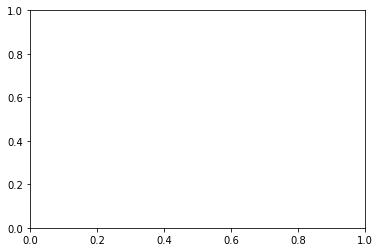

0it [00:00, ?it/s]

Using seed 8044 for randomized run
[{'model': 'ViT-B/32', 'weight': 1.0, 'prompt': 'South African Cave Painting of a Fractal'}]


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

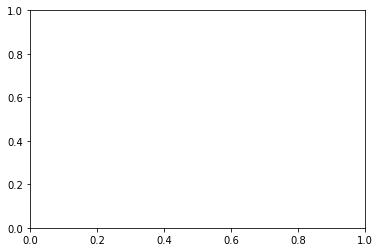

In [34]:
#@title ### 🔮 Inspiration
#@markdown  What do you want to see?
#@markdown  

try: advanced_cells_have_been_run 
except NameError: advanced_cells_have_been_run = False
if not advanced_cells_have_been_run:
    print( "ERROR: Before you can generate art, you need to run all the cells above this cell first -- including the cells in the Advanced Features section." )
    raise StopExecution


text_prompt = 'South African Cave Painting of a Fractal'#@param {type:'string'}
gen_seed = -1#@param {type:'number'}
save_art_output = True #@param {type:'boolean'}

#@markdown ### 🧩 Initialization
#@markdown You can use an init image to achieve some more control. The init image can be a url or you can upload it to colab and just include a filename. Try using images from previous runs with new prompts to better direct and morph your art!
init_image = ''#@param {type:'string'}
width = 800#@param {type:'number'}
height = 600#@param {type:'number'}
max_iter = 500#@param {type:'number'}

#@markdown There are different ways of generating the random starting point, when not using an init image. These influence how the image turns out. The default VQGAN ZRand is good, but some models and subjects may do better with perlin or pyramid noise.
#@markdown - If you want to keep starting from the same point, set `gen_seed` to a positive number. `-1` will make it random every time. 
rand_init_mode = 'VQGAN ZRand'#@param [ "VQGAN ZRand", "Perlin Noise", "Pyramid Noise"]
perlin_octaves = 2#@param {type:"slider", min:1, max:8, step:1}
perlin_weight = 0.22#@param {type:"slider", min:0, max:1, step:0.01}
pyramid_octaves = 5#@param {type:"slider", min:1, max:8, step:1}
pyramid_decay = 0.99#@param {type:"slider", min:0, max:1, step:0.01}
ema_val = 0.99

#@markdown ### 🎨 Generation
#@markdown Picking a different VQGAN model will impact how an image generates. Think of this as giving the generator a different set of brushes and paints to work with. CLIP is still the "eyes" and is judging the image against your prompt but using different brushes will make a different image.
#@markdown - `vqgan_imagenet_f16_16384` is the default and what most people use
vqgan_model = 'wikiart_16384'#@param [ "vqgan_imagenet_f16_1024", "vqgan_imagenet_f16_16384", "vqgan_openimages_f8_8192", "coco", "faceshq","wikiart_1024", "wikiart_16384", "sflckr"]

#@markdown ###👀 Perception
#@markdown How many slices of the image should be sent to CLIP each iteration to score? Higher numbers are better, but cost more memory. If you are running into memory issues try lowering this value.
cut_n =  128#@param {type:'number'}

#@markdown One clip model is good. Two is better? You may need to reduce the number of cuts to support having more than one CLIP model. CLIP is what scores the image against your prompt and each model has slightly different ideas of what things are.
#@markdown - `ViT-B/32` is fast and good and what most people use to begin with

clip_model = 'ViT-B/32' #@param ["ViT-B/16", "ViT-B/32", "RN50x16", "RN50x4","RN50","RN101","RN50x64"]
clip_model2 ='None' #@param ["None","ViT-B/16", "ViT-B/32", "RN50x16", "RN50x4", "RN50","RN101","RN50x64"]
if clip_model2 == "None":
    clip_model2 = None 
clip1_weight = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}

#@markdown ### 📉 Learning Rates & Weights
#@markdown Learning rates greatly impact how quickly an image can generate, or if an image can generate at all. The first learning rate is only for the first 50 iterations. The epoch rate is what is used after reaching the first mse epoch. 
#@markdown You can try lowering the epoch rate while raising the initial learning rate and see what happens
learning_rate = 0.2#@param {type:'number'}
learning_rate_epoch = 0.2#@param {type:'number'}
#@markdown How much should we try to match the init image, or if no init image how much should we resist change after reaching the first epoch?
mse_weight = 0.5 #@param {type:'number'}
#@markdown Adding some TV may make the image blurrier but also helps to get rid of noise. A good value to try might be 0.1.
tv_weight = 0.0 #@param {type:'number'}

#@markdown ---
#@markdown  <font size="5">😊</font> I'd love to see what you can make with my notebook. Tweet me your art [@remi_durant](https://twitter.com/remi_durant)!

output_as_png = True

run_args = argparse.Namespace(
    base_prompt = text_prompt,
    text_prompt = text_prompt,
    clip_model = clip_model,
    clip_model2 = clip_model2,
    clip1_weight = clip1_weight,
    gen_seed = gen_seed,
    #clip_models = clip_models,
    width = width,
    height = height,
    rand_init_mode = rand_init_mode,
    perlin_octaves = perlin_octaves,
    perlin_weight = perlin_weight,
    pyramid_octaves = pyramid_octaves,
    pyramid_decay = pyramid_decay,
    cut_n = cut_n,
    cut_weight_pow = cut_weight_pow,
    learning_rate = learning_rate,
    learning_rate_epoch = learning_rate_epoch,
    mse_weight = mse_weight,
    mse_epoch_step = mse_epoch_step,
    mse_epoch_count = mse_epoch_count,
    tv_weight = tv_weight,
    normalize_prompt_weights = normalize_prompt_weights,
    vqgan_model = vqgan_model,

    noise_frac_base = noise_frac_base,
)

if DoNoiseBurst:
    run_args.noise_burst_start = noise_burst_start
    run_args.noise_burst_end = noise_burst_end
    run_args.noise_burst_freq = noise_burst_freq
    run_args.noise_burst_length = noise_burst_length
    run_args.noise_frac_burst = noise_frac_burst

print('Using device:', device)
print('using prompts: ', text_prompt)

MultiClipLoss.perceptors = {} # remove any preloaded clip models
clear_memory()

model = get_vqgan_model( vqgan_model )

losses = []
mb = master_bar(range(1))
gnames = ['losses']

mb.names=gnames
mb.graph_fig, axs = plt.subplots(1, 1) # For custom display
mb.graph_ax = axs
mb.graph_out = display.display(mb.graph_fig, display_id=True)

## init step
def init():    
    randomize_run()

    BuildRunRecord()

    if run_args.clip_model2:     
        clip_models = [
            {'model':run_args.clip_model, 'weight':run_args.clip1_weight, 'prompt':run_args.text_prompt},
            {'model':run_args.clip_model2, 'weight':1.0 - run_args.clip1_weight, 'prompt':run_args.text_prompt},
        ]
    else:
        clip_models = [
            {'model':run_args.clip_model, 'weight':1.0, 'prompt':run_args.text_prompt},
        ]

    print( clip_models )

    global clip_loss
    clip_loss = MultiClipLoss( clip_models, 
        normalize_prompt_weights = run_args.normalize_prompt_weights, 
        cutn = run_args.cut_n, 
        cut_weight_pow = run_args.cut_weight_pow)

    # reset seed before making init image
    # (this should already be set to something other than -1 from calling randomize_run)
    run_args.gen_seed = update_random( run_args.gen_seed, 'image generation')
        
    # Make Z Init
    global z
    z = 0

    f = 2**(model.decoder.num_resolutions - 1)
    toksX, toksY = math.ceil( run_args.width / f), math.ceil( run_args.height / f)

    print(f'Outputing size: [{toksX*f}x{toksY*f}]')
    run_args.width = toksX * f
    run_args.height = toksY * f
    
    global init_image
    
    if resume_from_last and last_image_saved is not None:
        print("Resuming from last generation")
        init_image = last_image_saved

    has_init_image = (init_image != "")
    if has_init_image:
        if 'http' in init_image:
            req = Request(init_image, headers={'User-Agent': 'Mozilla/5.0'})
            img = Image.open(urlopen(req))
        else:
            img = Image.open(init_image)

        pil_image = img.convert('RGB')
        pil_image = pil_image.resize((toksX * f, toksY * f), Image.LANCZOS)
        pil_image = TF.to_tensor(pil_image)
        #if args.use_noise:
        #  pil_image = pil_image + args.use_noise * torch.randn_like(pil_image) 
        z, *_ = model.encode(pil_image.to(device).unsqueeze(0) * 2 - 1)
        del pil_image
        del img

    else:
        z = make_rand_init( run_args.rand_init_mode, model, run_args.perlin_octaves, run_args.perlin_weight, run_args.pyramid_octaves, run_args.pyramid_decay, toksX, toksY, f )
        
    z = EMATensor(z, ema_val)
    
    global opt
    opt = optim.Adam( z.parameters(), lr=run_args.learning_rate, weight_decay=0.00000000)

    global mse_loss
    mse_loss = MSEDecayLoss( run_args.mse_weight, 
                            mse_decay_rate = mse_epoch_step, 
                            mse_epoches = mse_epoch_count, 
                            mse_quantize=True )
    mse_loss.set_target( z.tensor, model )
    mse_loss.has_init_image = has_init_image

    global tv_loss
    tv_loss = TVLoss() 

## optimizer loop

def synth(z, quantize=True, scramble=True):
    z_q = 0
    if quantize:
      z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    else:
      z_q = z.model

    out = clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

    return out

@torch.no_grad()
def checkin(i, z, out_pil, losses):
    losses_str = ', '.join(f'{loss.item():g}' for loss in losses)

    print( 'Prompt:', run_args.text_prompt )
    tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')

    display_format='png' if output_as_png else 'jpg'
    pil_data = image_to_data_url(out_pil, display_format)
    
    display.display(display.HTML(f'<img src="{pil_data}" />'))

def train(i):
    global opt
    global z 
    opt.zero_grad( set_to_none = True )

    out = checkpoint( synth, z.tensor )

    clip_loss.noise_aug.frac = get_noise_frac(i)

    lossAll = []
    lossAll += clip_loss( i,out )

    if 0 < run_args.mse_weight:
        msel = mse_loss(i,z.tensor)
        if 0 < msel:
            lossAll.append(msel)
    
    if 0 < run_args.tv_weight:
        lossAll.append(tv_loss(out)*run_args.tv_weight)
    
    loss = sum(lossAll)
    loss.backward()

    if should_checkin(i) or should_save_for_video(i):
        with torch.no_grad():
            if use_ema_tensor:
                out = synth( z.average )

            pil = TF.to_pil_image(out[0].cpu())

            if should_checkin(i):
                if not headless:
                    checkin(i, z, pil, lossAll)
                SaveRunIteration( i, pil )
            
            if should_save_for_video(i):
                save_frame_for_video(i, pil)   

    # update graph
    losses.append(loss.item())
    x = range(len(losses))
    mb.update_graph( [[x,losses]] )

    opt.step()
    if use_ema_tensor:
      z.update()

set_drive_output_subfolder()

run_limit = 1
if BatchRunOverride:
    run_limit = batch_run_limit

from IPython.display import clear_output 
runs = 0
try:
    with tqdm() as pbar:
        while runs < run_limit or run_limit == -1:
            init()

            i = 0
            losses = []

            # clear out folder for video frames
            if save_frames_for_video:                                
                !rm -r steps
                !mkdir -p steps
            
            while True and i <= max_iter:
        
                if i % 200 == 0:
                    clear_memory()

                train(i)

                with torch.no_grad():
                    should_do_mse_epoch = mse_loss.step(i)
                    if should_do_mse_epoch or should_do_animation_step(i):
                        
                        if should_do_mse_epoch:
                            print(f'Reseting optimizer at mse epoch (i: {i})')

                            if mse_loss.has_init_image and use_ema_tensor:
                                mse_loss.set_target(z.average,model)
                            else:
                                mse_loss.set_target(z.tensor,model)                            
                             
                            # Make sure not to spike loss when mse_loss turns on
                            if not mse_loss.is_active(i):
                                z.tensor = nn.Parameter(mse_loss.z_orig.clone())
                                z.tensor.requires_grad = True
                            
                        if should_do_animation_step(i):
                            print(f'Applying animation step and reseting optimizer (i: {i})')
                            do_anim_step()

                            mse_loss.set_target(z.tensor,model)

                        if use_ema_tensor:
                            z = EMATensor(z.average, ema_val)
                        else:
                            z = EMATensor(z.tensor, ema_val)
                        
                        opt = optim.Adam(z.parameters(), lr=run_args.learning_rate_epoch, weight_decay=0.00000000)

                # step completed
                if not BatchRunOverride:
                    pbar.update()
                i += 1
                
            if save_frames_for_video and autogenerate_video_after_run:
                save_video()

            # image completed
            if BatchRunOverride:
                pbar.update()
            runs += 1

except KeyboardInterrupt:
    pass



In [ ]:
#@title 🎥 Make a Video of Your Last Run!
#@markdown If you want to make a video, you must first enable `save_frames_for_video` in the Advanced section.

save_video()